In [7]:
import time
import numpy as np
import seaborn as sbn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Performance/Optimizations
EnableDaal4py = False    # Optimise sklearn for Intel CPUs (Requires daal4py)

verbose = 2
shuffleSeed = 0     # Data shuffle seed.
kFoldSeed = None    # Cross-validation shuffle seed.
targetCores = 7     # How many cores to use.
trainSize = 0.8
testSize = 0.2

# Path to the miniboone dataset
dataPath = "../datasets/"

# Set up a basic 5-fold cross-validation.
cv = KFold(n_splits=5, shuffle=True, random_state=kFoldSeed)

if (EnableDaal4py == True):
    from daal4py.sklearn import patch_sklearn
    patch_sklearn()

In [9]:
class MinibooneLoader():

    totalEvents = 0
    totalSignals = 0
    totalBackgrounds = 0

    events = []
    classifications = []

    def loadMiniboone(self):
        """
        Loads and initialises itself from the dataset.

        Returns:
            self (MinibooneLoader): It's own self for fluent invocation.
        """
        eventsBuffer = []

        with open(f'{dataPath}MiniBooNE_PID.txt', 'r') as dataFile:

            # Loading and parsing the event totals.
            totals = dataFile.readline().strip()
            self.totalSignals, self.totalBackgrounds = [int(i) for i in totals.split(' ')]
            self.totalEvents = self.totalBackgrounds + self.totalSignals

            # Parse the data points in the file to a raw array.
            eventsBuffer = [event for event in self.linesAsNums(dataFile)]
    
        # Map the data to a new numpy array.
        self.events = np.array(eventsBuffer)
        
        signals = np.full(self.totalSignals, 0)
        backgrounds = np.full(self.totalBackgrounds, 1)

        self.classifications = np.concatenate((signals, backgrounds))
        return self
    
    def linesAsNums(self, file):
        """
        Iterator for a given file buffer, performing the following:
        * Stripping whitespace
        * Splitting by whitespace.
        * Parsing each substring as a float.
        * Yields it.

        Args:
            file ([IO]): A valid file buffer, starting at the first line to load.

        Yields:
            floats (float[]): The obtained floats from the file.
        """
        strings = []
        for line in file:
            strings = line.strip().split()
            yield [float(num) for num in strings]


In [8]:
def fitGridSearch(search: GridSearchCV, X_train, y_train):
    """
    Perform a fitting on a preconfigured grid-search.
    Once done, report the results

    Args:
        search (GridSearchCV): A valid, configured grid search object.
        X_train (Iterable): Your models training data.
        y_train (Iterable): Your training datas classifications.

    Yields:
        search (GridSearchCV): The same grid search used.
    """

    search.fit(X_train, y_train)

    # Print the results of the above grid search.
    print('\nBest Score: %s' % search.best_score_)
    print('Best Hyperparameters: %s\n' % search.best_params_)

    # Report all the scores for all the various combinations.
    means = search.cv_results_['mean_test_score']
    stds = search.cv_results_['std_test_score']

    # Print the mean accuracy and expected deviation for all parameter combinations.
    print('Performance breakdown for each fit:')
    for mean, std, params in zip(means, stds, search.cv_results_['params']):
        print('%0.3f (+/-%0.03f) for %r' % (mean, std * 2, params))
    
    return search

def testAlgorithm(search: GridSearchCV, X_test, y_test):
    """
    Test a fitted GridSearch result, reporting on the performance and time duration.

    Args:
        search (GridSearchCV): A valid, configured grid search object.
        X_test (Iterable): Your models test data.
        y_test (Iterable): Your test datas classifications.

    Yields:
        search (GridSearchCV): The same grid search used.
    """

    # Test the selected hyperparameters on the test set.
    timeStart = time.time() * 1000
    predictions = search.predict(X_test)
    timeEnd = time.time() * 1000
    totalTime = timeEnd - timeStart

    print('\nTotal prediction time: {}ms\nAverage time/prediction: {}ms'.format(totalTime, totalTime / len(X_test)))

    print('\nClassification report:')
    print(classification_report(y_test, predictions))
    
    print('\nConfusion matrix:')
    plotConfusionMatrix(confusion_matrix(y_test, predictions))

def plotConfusionMatrix(cf_matrix):
    # Generate the cells for the confusion matrix
    group_names = ["True Pos", "False Pos", "True Neg", "False Neg"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.4%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    # Create the matrix itself
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    # Render as a heatmap
    sbn.heatmap(cf_matrix, annot=labels, fmt="", cmap="Blues")

In [10]:
dataset = MinibooneLoader().loadMiniboone()

events = dataset.events

In [11]:
# Set up a preprocessing pipeline
estimators = [
    # Standardizes and scales the dataset
    ['scale', StandardScaler()]
]
pipe = Pipeline(estimators).fit(events)

# Transform the data using the prepared pipeline.
X = pipe.transform(events)
y = dataset.classifications

In [12]:

# Shuffle the dataset and split into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=shuffleSeed, train_size=trainSize, test_size=testSize)

print('Data has been split. Training data:')
print(X_train)
print(y_train)

Data has been split. Training data:
[[ 0.04852549  0.05710245 -0.42166557 ...  0.04230077  0.08020339
   0.0614591 ]
 [ 0.08522973  0.05787857  0.40372423 ...  0.15819105  0.06338857
   0.0602966 ]
 [ 0.03886527  0.05797087 -0.56084576 ...  0.03024111  0.03142102
   0.06056402]
 ...
 [ 0.06007261  0.07552737  0.02669232 ...  0.06275209  0.08296288
   0.06197942]
 [ 0.06221417  0.06761905 -0.02986604 ...  0.07141983  0.07571434
   0.05977339]
 [ 0.06484492  0.0546634   0.00282108 ...  0.0365456   0.03887806
   0.0591355 ]]
[0 1 0 ... 1 1 1]


Fitting 5 folds for each of 96 candidates, totalling 480 fits
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:  4.7min
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed: 26.0min
[Parallel(n_jobs=7)]: Done 351 tasks      | elapsed: 59.5min
[Parallel(n_jobs=7)]: Done 480 out of 480 | elapsed: 79.4min finished

Best Score: 0.9390491254775046
Best Hyperparameters: {'activation': 'relu', 'epsilon': 1e-07, 'hidden_layer_sizes': (25, 25), 'max_iter': 500, 'n_iter_no_change': 20}

Performance breakdown for each fit:
0.928 (+/-0.005) for {'activation': 'tanh', 'epsilon': 1e-07, 'hidden_layer_sizes': (5, 5, 5), 'max_iter': 500, 'n_iter_no_change': 10}
0.931 (+/-0.005) for {'activation': 'tanh', 'epsilon': 1e-07, 'hidden_layer_sizes': (5, 5, 5), 'max_iter': 500, 'n_iter_no_change': 20}
0.927 (+/-0.004) for {'activation': 'tanh', 'epsilon': 1e-07, 'hidden_layer_sizes': (5, 5, 5), 'max_iter': 250, 'n_iter_no_change': 1

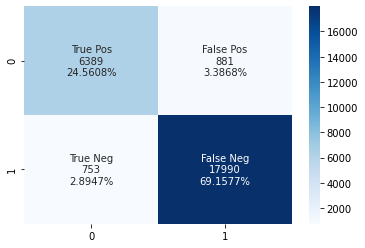

In [13]:
# Define our hyperameter grid-space.
parameters={
    'hidden_layer_sizes': (
        # (10, 10, 10),
        (5, 5, 5),
        (25, 25),
        # (10, 10),
        (5, 5),
        (25)
    ),
    'max_iter': ( 500, 250, 100 ),
    'activation': ( 'tanh', 'relu' ),
    'n_iter_no_change': ( 10, 20 ),
    'epsilon': (1e-7, 1e-8)
}

# Define our estimator
mlp=MLPClassifier()
# Set up the final grid-search
nn_search = GridSearchCV(estimator=mlp, param_grid=parameters, cv=cv, scoring='accuracy', n_jobs=targetCores, verbose=verbose)

fitGridSearch(nn_search, X_train, y_train)
testAlgorithm(nn_search, X_test, y_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done 162 tasks      | elapsed:  7.3min
[Parallel(n_jobs=7)]: Done 365 tasks      | elapsed: 28.9min
[Parallel(n_jobs=7)]: Done 600 out of 600 | elapsed: 43.9min finished

Best Score: 0.9011542490224196
Best Hyperparameters: {'class_weight': None, 'dual': True, 'max_iter': 1000, 'penalty': 'l2', 'tol': 1e-05}

Performance breakdown for each fit:
nan (+/-nan) for {'class_weight': None, 'dual': True, 'max_iter': 1000, 'penalty': 'l1', 'tol': 0.0001}
nan (+/-nan) for {'class_weight': None, 'dual': True, 'max_iter': 1000, 'penalty': 'l1', 'tol': 1e-05}
nan (+/-nan) for {'class_weight': None, 'dual': True, 'max_iter': 1000, 'penalty': 'l1', 'tol': 5e-05}
0.900 (+/-0.005) for {'class_weight': None, 'dual': True, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.0001}
0.901 (+/-0.00

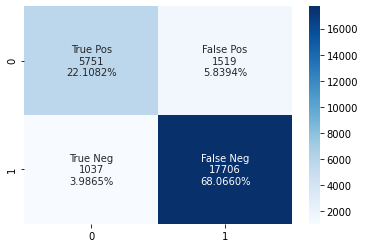

In [14]:
# NOTE: loss not set to hinge. Causes NaN accuracy and doesn't run.
# Define our hyperameter grid-space.
parameters={
    'penalty': ('l1', 'l2'),
    'dual': (True, False),
    'tol': (1e-4, 1e-5, 5e-5),
    'class_weight': (None, 'balanced'),
    'max_iter': (1000, 2000, 500, 250, 100)
}

# Define our SVM. LinearSVC is used in this case since it is more optimized for larger datasets than SVC.
svm=LinearSVC()
# Set up the final grid-search
svm_search = GridSearchCV(estimator=svm, param_grid=parameters, cv=cv, scoring='accuracy', n_jobs=targetCores, verbose=verbose)

fitGridSearch(svm_search, X_train, y_train)
testAlgorithm(svm_search, X_test, y_test)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:  6.1min
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed: 33.8min
[Parallel(n_jobs=7)]: Done 351 tasks      | elapsed: 74.3min
[Parallel(n_jobs=7)]: Done 634 tasks      | elapsed: 132.8min
[Parallel(n_jobs=7)]: Done 999 tasks      | elapsed: 209.8min
[Parallel(n_jobs=7)]: Done 1440 out of 1440 | elapsed: 295.7min finished

Best Score: 0.9375498324304568
Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 250, 'oob_score': True}

Performance breakdown for each fit:
0.928 (+/-0.004) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': False}
0.928 (+/-0.005) for {'class_weight': 'balan

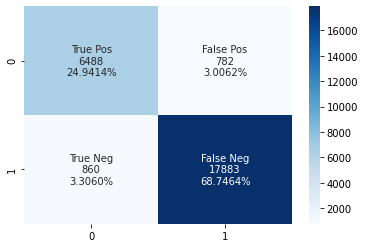

In [15]:
# Perform grid search to identify the best hyperparameters

# NOTE: loss not set to hinge. Causes NaN accuracy and doesn't run.
# Define our hyperameter grid-space.
parameters={
    'n_estimators': (10, 100, 250),
    'criterion': ('gini', 'entropy'),
    'min_samples_split': (2, 5),
    'min_samples_leaf': (2, 5),
    'class_weight': ('balanced', 'balanced_subsample', None),
    'max_features': ('auto', 'log2'),
    'oob_score': (False, True)
}

# Define our Random forest classifier.
rf=RandomForestClassifier()
# Set up the final grid-search
rf_search = GridSearchCV(estimator=rf, param_grid=parameters, cv=cv, scoring='accuracy', n_jobs=targetCores, verbose=verbose)

fitGridSearch(rf_search, X_train, y_train)
testAlgorithm(rf_search, X_test, y_test)